# Compare CASTEP al3x3 benchmark performance

This notebook compares the performance of the small al3x3 benchmark across different UK HPC facilities.

## Setup section

Import the required modules and define useful functions.

In [1]:
import re
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("white", {"font.family": "serif"})
sns.set_context("paper")

Define a function to get the mean SCF cycle time from CASTEP output file. Minimum and maximum times found are removed before mean is computed to remove skewing due to long first step or very short step.

In [2]:
def getmeancycle(castepfilename):
    infile = open(castepfilename, 'r')
    tvals = []
    for line in infile:
        if re.search('<-- SCF', line):
            line = line.strip()
            tokens = line.split()
            if re.match('[0-9]+', tokens[0].lstrip()):
                tvals.append(float(tokens[4]))
    infile.close()

    deltat = []
    for i in range(len(tvals)-1):
        deltat.append(tvals[i+1] - tvals[i])
        
    deltat.remove(max(deltat))
    deltat.remove(min(deltat))
    
    return sum(deltat)/len(deltat)

Define a function to setup arrays of performance data for each system. Takes dictionary of CASTEP output files keyed by number of nodes and the number of cores per node. (Assumes all nodes are fully-populated.) Also print a summary of the data.

In [3]:
def calcperf(filedict, cpn):
    coreslist = []
    scflist = []
    sulist = []
    print("{:>15s} {:>15s} {:>15s} {:>15s}".format('Nodes', 'Cores', 'Mean SCF (s)', 'Speedup'))
    print("{:>15s} {:>15s} {:>15s} {:>15s}".format('=====', '=====', '============', '======='))
    for nodes, filename in sorted(filedict.items()):
        coreslist.append(nodes*cpn)
        scf = getmeancycle(filename)
        scflist.append(scf)
        speedup = scflist[0]/scf
        sulist.append(speedup)
        print("{:>15d} {:>15d} {:>15.1f} {:>15.2f}".format(nodes, nodes*cpn, scf, speedup))
    return coreslist, scflist, sulist

## Read data and compute performance

### Cirrus

Cirrus results have versions compiled with both SGI MPT and Intel MPI

In [4]:
cirrusmptfiles = {1:'../al3x3/results/Cirrus/16.11_intel17_mpt214/al3x3.castep.1nodes',
                  2:'../al3x3/results/Cirrus/16.11_intel17_mpt214/al3x3.castep.2nodes',
                  4:'../al3x3/results/Cirrus/16.11_intel17_mpt214/al3x3.castep.4nodes',
                  8:'../al3x3/results/Cirrus/16.11_intel17_mpt214/al3x3.castep.8nodes',
                  16:'../al3x3/results/Cirrus/16.11_intel17_mpt214/al3x3.castep.16nodes'}

In [5]:
cirrusmptcpn = 36
cirrusmptcores, cirrusmptscf, cirrusmptsu = calcperf(cirrusmptfiles, cirrusmptcpn)

          Nodes           Cores    Mean SCF (s)         Speedup
          =====           =====    ============         =======
              1              36           102.4            1.00
              2              72            50.0            2.05
              4             144            31.4            3.27
              8             288            20.3            5.04
             16             576            20.7            4.95


In [6]:
cirrusimpifiles = {1:'../al3x3/results/Cirrus/17.21_gcc620_impi17/al3x3.castep.1nodes',
                  2:'../al3x3/results/Cirrus/17.21_gcc620_impi17/al3x3.castep.2nodes',
                  4:'../al3x3/results/Cirrus/17.21_gcc620_impi17/al3x3.castep.4nodes',
                  8:'../al3x3/results/Cirrus/17.21_gcc620_impi17/al3x3.castep.8nodes'}

In [7]:
cirrusimpicpn = 36
cirrusimpicores, cirrusimpiscf, cirrusimpisu = calcperf(cirrusimpifiles, cirrusimpicpn)

          Nodes           Cores    Mean SCF (s)         Speedup
          =====           =====    ============         =======
              1              36            90.1            1.00
              2              72            48.0            1.88
              4             144            31.5            2.86
              8             288            30.2            2.98


### Thomas

In [8]:
thomasfiles = {1:'../al3x3/results/Thomas/al3x3.castep.1nodes',
               2:'../al3x3/results/Thomas/al3x3.castep.2nodes',
               4:'../al3x3/results/Thomas/al3x3.castep.4nodes',
               8:'../al3x3/results/Thomas/al3x3.castep.8nodes'}

In [9]:
thomascpn = 24
thomascores, thomasscf, thomassu = calcperf(thomasfiles, thomascpn)

          Nodes           Cores    Mean SCF (s)         Speedup
          =====           =====    ============         =======
              1              24           123.3            1.00
              2              48            52.9            2.33
              4              96            30.0            4.12
              8             192            18.7            6.59


### Athena

In [10]:
athenafiles = {1:'../al3x3/results/Athena/al3x3.castep.1nodes',
               2:'../al3x3/results/Athena/al3x3.castep.2nodes',
               4:'../al3x3/results/Athena/al3x3.castep.4nodes',
               8:'../al3x3/results/Athena/al3x3.castep.8nodes',
               16:'../al3x3/results/Athena/al3x3.castep.16nodes'}

In [11]:
athenacpn = 28
athenacores, athenascf, athenasu = calcperf(athenafiles, athenacpn)

          Nodes           Cores    Mean SCF (s)         Speedup
          =====           =====    ============         =======
              1              28           100.6            1.00
              2              56            48.7            2.07
              4             112            40.1            2.51
              8             224            15.2            6.62
             16             448            18.8            5.35


### ARCHER

In [12]:
archerfiles = {1:'../al3x3/results/ARCHER/al3x3.castep.1nodes',
               2:'../al3x3/results/ARCHER/al3x3.castep.2nodes',
               4:'../al3x3/results/ARCHER/al3x3.castep.4nodes',
               8:'../al3x3/results/ARCHER/al3x3.castep.8nodes'}

In [13]:
archercpn = 24
archercores, archerscf, archersu = calcperf(archerfiles, archercpn)

          Nodes           Cores    Mean SCF (s)         Speedup
          =====           =====    ============         =======
              1              24           184.2            1.00
              2              48            88.2            2.09
              4              96            51.3            3.59
              8             192            33.2            5.55


### CSD3-Skylake

In [14]:
csd3skyfiles = {1:'../al3x3/results/CSD3-Skylake/al3x3.castep.1nodes',
                2:'../al3x3/results/CSD3-Skylake/al3x3.castep.2nodes',
                4:'../al3x3/results/CSD3-Skylake/al3x3.castep.4nodes',
                8:'../al3x3/results/CSD3-Skylake/al3x3.castep.8nodes',
                16:'../al3x3/results/CSD3-Skylake/al3x3.castep.16nodes',}

In [15]:
csd3skycpn = 32
csd3skycores, csd3skyscf, csd3skysu = calcperf(csd3skyfiles, csd3skycpn)

          Nodes           Cores    Mean SCF (s)         Speedup
          =====           =====    ============         =======
              1              32            61.3            1.00
              2              64            31.4            1.95
              4             128            19.7            3.10
              8             256            14.1            4.35
             16             512            10.5            5.81


## Performance Comparison

### Mean SCF cycle time

This plot shows that performance for this benchmark is dominated by the on-node performance (processor/memory) as the more modern Xeon processors on the Tier-2 systems (CSD3-Skylake, Cirrus, Thomas, Athena) outperform the older Xeon processors on ARCHER; and the most modern processors (CSD3-Skylake) with the highest processor performance and memory bandwidth show the best performance.

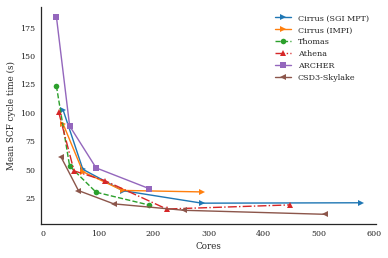

In [16]:
plt.plot(cirrusmptcores, cirrusmptscf, '>-', label='Cirrus (SGI MPT)')
plt.plot(cirrusimpicores, cirrusimpiscf, '>-', label='Cirrus (IMPI)')
plt.plot(thomascores, thomasscf, 'o--', label='Thomas')
plt.plot(athenacores, athenascf, '^-.', label='Athena')
plt.plot(archercores, archerscf, 's-', label='ARCHER')
plt.plot(csd3skycores, csd3skyscf, '<-', label='CSD3-Skylake')
plt.xlabel('Cores')
plt.ylabel('Mean SCF cycle time (s)')
plt.legend(loc='best')
sns.despine()

Highest absolute performance is on the CSD3-Skylake system. Broadwell system performance increases as the cores-per-node decreases: Thomas (24 core per node) is best. Why? Less cores gives more memory bandwidth per core and more interconnect bandwith per core. ARCHER has lowest absolute performance due to having oldest generation of processors.

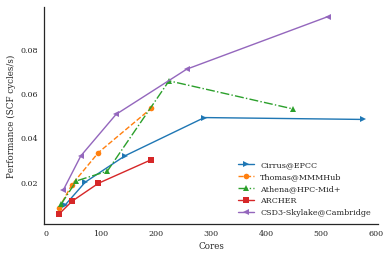

In [20]:
plt.plot(cirrusmptcores, [1/x for x in cirrusmptscf], '>-', label='Cirrus@EPCC')
plt.plot(thomascores, [1/x for x in thomasscf], 'o--', label='Thomas@MMMHub')
plt.plot(athenacores, [1/x for x in athenascf], '^-.', label='Athena@HPC-Mid+')
plt.plot(archercores, [1/x for x in archerscf], 's-', label='ARCHER')
plt.plot(csd3skycores, [1/x for x in csd3skyscf], '<-', label='CSD3-Skylake@Cambridge')
plt.xlabel('Cores')
plt.ylabel('Performance (SCF cycles/s)')
plt.legend(loc='best')
sns.despine()
plt.savefig('castep_al3x3perf.png', dpi=300)

## Single node performance comparisons

In [23]:
nperf = {}
cperf = {}
nperf['ARCHER'] = archerscf[0]
cperf['ARCHER'] = archerscf[0]/(archercpn)
nperf['Cirrus'] = cirrusmptscf[0]
cperf['Cirrus'] = cirrusmptscf[0]/(cirrusmptcpn)
nperf['Thomas'] = thomasscf[0]
cperf['Thomas'] = thomasscf[0]/(thomascpn)
nperf['Athena'] = athenascf[0]
cperf['Athena'] = athenascf[0]/(athenacpn)
nperf['CSD3-Skylake'] = csd3skyscf[0]
cperf['CSD3-Skylake'] = csd3skyscf[0]/(csd3skycpn)

print("Performance improvement relative to ARCHER:\n")
print("{:>15s} {:>15s} {:>15s}".format('System', 'Mean SCF (s)', 'Improvement'))
print("{:>15s} {:>15s} {:>15s}".format('======', '============', '==========='))
print("1-node (per node)")
for system in sorted(nperf):
    print("{:>15s} {:>15.3f} {:>15.3f}".format(system, nperf[system], nperf['ARCHER']/nperf[system]))

print("per-core")
for system in sorted(cperf):
    print("{:>15s} {:>15.3f} {:>15.3f}".format(system, cperf[system], cperf['ARCHER']/cperf[system]))

Performance improvement relative to ARCHER:

         System    Mean SCF (s)     Improvement
         ======    ============     ===========
1-node (per node)
         ARCHER         184.184           1.000
         Athena         100.600           1.831
   CSD3-Skylake          61.280           3.006
         Cirrus         102.421           1.798
         Thomas         123.312           1.494
per-core
         ARCHER           7.674           1.000
         Athena           3.593           2.136
   CSD3-Skylake           1.915           4.007
         Cirrus           2.845           2.697
         Thomas           5.138           1.494


Theoretical memory bandwidth ratios:

* E5v2:E5v4 = 1.0:1.3
* E5v2:Gold = 1.0:2.0
* E5v4:Gold = 1.0:1.6

Core counts:

* ARCHER: 24 cores, 2.7GHz
* Athena: 28 cores, 2.4GHz
* CSD3-Skylake: 32 cores, 2.6GHz
* Cirrus: 36 cores, 2.1GHz
* Thomas: 24 cores, 2.1GHz

Performance of this benchmark is a function of both memory bandwidth, architecture and core count (probably due to increased shared memory for all-to-all). For example, ARCHER and Thomas have same core counts but Thomas gets a bigger performance jump than memory bandwidth alone would suggest (even though the processors are slower). This suggests the architecture (FP unit, cache structure, DDR4 vs DDR3) are also having a positive effect. This is also seen in the Skylake performance which is 3x faster than ARCHER when memory bandwidth alone is only 2x better. We would still expect that memory bandwidth is a large part of this performance increase.

# Patched system comparison

In [28]:
csd3spatch_files = {1:'../al3x3/results/CSD3-Skylake-patched/al3x3.castep.1nodes',
                    2:'../al3x3/results/CSD3-Skylake-patched/al3x3.castep.2nodes',
                4:'../al3x3/results/CSD3-Skylake-patched/al3x3.castep.4nodes',
                8:'../al3x3/results/CSD3-Skylake-patched/al3x3.castep.8nodes',
                16:'../al3x3/results/CSD3-Skylake-patched/al3x3.castep.16nodes',}

In [29]:
csd3spatch_cores, csd3spatch_scf, csd3spatch_su = calcperf(csd3spatch_files, csd3skycpn)

          Nodes           Cores    Mean SCF (s)         Speedup
          =====           =====    ============         =======
              1              32            60.9            1.00
              2              64            44.6            1.36
              4             128            19.9            3.06
              8             256            13.7            4.45
             16             512            11.5            5.31


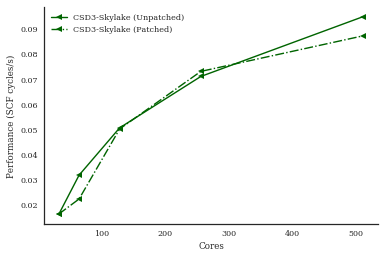

In [30]:
plt.plot(csd3skycores, [1/x for x in csd3skyscf], '<-', color='darkgreen', label='CSD3-Skylake (Unpatched)')
plt.plot(csd3spatch_cores, [1/x for x in csd3spatch_scf], '<-.', color='darkgreen', label='CSD3-Skylake (Patched)')
plt.xlabel('Cores')
plt.ylabel('Performance (SCF cycles/s)')
plt.legend(loc='best')
sns.despine()